In [182]:
%load_ext autoreload
%autoreload 2
import numpy as np

In [183]:
vl = 3
vr = 1
d = 1

v_avg = (vl + vr) / 2
r_c = d/2 * (vl + vr) / (vl - vr)
w = np.atan2(-np.sign(r_c) * v_avg, abs(r_c))
print(f"v_avg: {v_avg}, r_c: {r_c}, w: {w}")

v_avg: 2.0, r_c: 1.0, w: -1.1071487177940904


In [ ]:
def dynamics(a0, vl, vr, d):
    if vr != vl:
        v_avg = (vl + vr) / 2
        r_c = d/2 * (vl + vr) / (vl - vr)
        w = np.atan2(-1 * np.sign(r_c) * v_avg, abs(r_c))
        v_c = 0
    else:
        r_c = np.inf
        w = 0
        v_c = np.array([0, vl]) # or vr, since vl == vr in this case
        
    return v_c, w, r_c
    
def state_update(x0, a0, dt, vl, vr, d):
    # Update the state based on the wheel velocities
    v_c, w, r_c = dynamics(a0, vl, vr, d)
    # xf = x0 + v * dt
    delta_a = w * dt
    if r_c == np.inf:
        # Straight line motion
        delta_x_body = v_c * dt
    else:
        # Circular motion
        delta_x_body = -1 * r_c * np.array([np.cos(delta_a) - 1, np.sin(delta_a)])
    delta_x = np.array([[np.cos(a0), -np.sin(a0)], [np.sin(a0), np.cos(a0)]]) @ delta_x_body
    xf = x0 + delta_x
    af = a0 + delta_a
    print(f"v: {v_c}, w: {w}, r: {r_c}, xf: {xf}, af: {af}")
    return xf, af


In [192]:
import pygame

def setup_joystick():

    pygame.init()
    pygame.joystick.init()

    if pygame.joystick.get_count() == 0:
        print("No joystick detected!")
        exit()

    joystick = pygame.joystick.Joystick(0)
    joystick.init()

    return joystick

def axis_to_rpm(axis_val, MIN_RPM, MAX_RPM):
    # Map -1.0 to 1.0 to MIN_RPM to MAX_RPM
    return axis_val * (MAX_RPM - MIN_RPM) + MIN_RPM

def joystick_to_wheel_rpms(joystick, MIN_RPM = 0, MAX_RPM = 100, CRAB_TURN_RPM = 40):
    # axis 0: left stick horizontal
    # 1: left vertical (inverted)
    # 2: right horizontal
    # 3: right vertical (inverted)
    # 4: right trigger
    # 5: left trigger

    # button 0: A
    # 1: B

    # hat 0: d pad horizontal
    # hat 1: d pad vertical (not inverted)

    # Get controller inputs
    left_stick_horiz = joystick.get_axis(0)
    right_trigger = joystick.get_axis(4)
    left_trigger = joystick.get_axis(5)
    dpad_horiz = joystick.get_hat(0)[0]
    button_b = joystick.get_button(1)
    
    # right trigger for forward speed
    right_trigger += 1.0  # make it positive
    right_trigger /= 2.0  # scale to 0.0 to 1.0
    total_for_rpm = axis_to_rpm(right_trigger, MIN_RPM, MAX_RPM)

    # left trigger for reverse speed
    left_trigger += 1.0  # make it positive
    left_trigger /= 2.0
    total_rev_rpm = axis_to_rpm(left_trigger, MIN_RPM, MAX_RPM)

    # determine direction
    if total_for_rpm > total_rev_rpm:
        direction = 1
        total_rpm = total_for_rpm
    else:
        direction = -1
        total_rpm = -total_rev_rpm                

    # if B button is pressed, boost speed
    if button_b:
        total_rpm *= 1.8

    # adjust individual wheel RPMs based on left stick
    DAMPING_COEFF = 0.9
    LEFT_STICK_DEADZONE = 0.1
    if left_stick_horiz < -LEFT_STICK_DEADZONE:
        left_rpm = total_rpm * (1.0 - abs(left_stick_horiz) * DAMPING_COEFF)
        right_rpm = total_rpm
    elif left_stick_horiz > LEFT_STICK_DEADZONE:
        right_rpm = total_rpm * (1.0 - abs(left_stick_horiz) * DAMPING_COEFF)
        left_rpm = total_rpm
    else:
        left_rpm = total_rpm
        right_rpm = total_rpm

    # override controls with crab turn
    if dpad_horiz < 0:
        left_rpm = -CRAB_TURN_RPM
        right_rpm = CRAB_TURN_RPM
    elif dpad_horiz > 0:
        left_rpm = CRAB_TURN_RPM
        right_rpm = -CRAB_TURN_RPM

    # fix left motor direction
    left_rpm *= -1

    return left_rpm, right_rpm

No joystick detected!


error: Invalid joystick device number

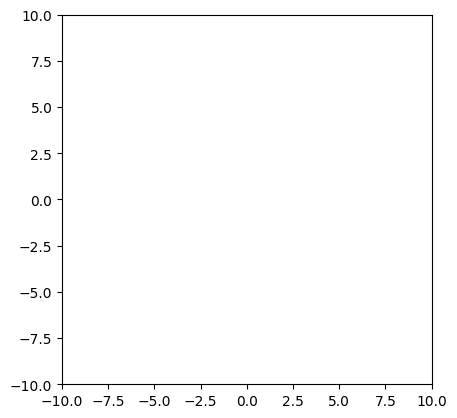

: 

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import time

d = 0.3 # distance between wheels [m]
wheel_radius = 0.07 # radius of the wheels [m]

x0 = np.array([0, 0]) # initial position [m]
a0 = 0 # initial angle [rad]
dt = 0.1 # time step [s]
t = 0

# Initialize the plot
fig, ax = plt.subplots()
ax.set_aspect('equal')  # Make the figure square
x_data = []
y_data = []
line, = ax.plot(x_data, y_data)
ax.set_xlim(-10, 10) # Set fixed x-axis limits
ax.set_ylim(-10, 10) # Set fixed y-axis limits

# get current system time
start_time = time.time()

joystick = setup_joystick()

i = 0
try:
    while True:

        pygame.event.pump()
        rpm_l, rpm_r = joystick_to_wheel_rpms(joystick, 0, 100)
        vr *= -1  # fix left motor direction
        vl = rpm_l * 2 * np.pi / 60 * wheel_radius
        vr = rpm_r * 2 * np.pi / 60 * wheel_radius 
        print(f"vl: {vl}, vr: {vr}")

        xf, af = state_update(x0, a0, dt, vl, vr, d)

        # Update data
        x_data.append(xf[0])
        y_data.append(xf[1])
        line.set_data(x_data, y_data)

        # Remove previous heading line if it exists
        if hasattr(ax, 'heading_line'):
            ax.heading_line.remove()

        # Calculate the end point of the heading line
        x_l = xf[0] - d/2 * np.cos(af)
        x_r = xf[0] + d/2 * np.cos(af)
        y_l = xf[1] - d/2 * np.sin(af)
        y_r = xf[1] + d/2 * np.sin(af)

        # Draw the heading line
        ax.heading_line, = ax.plot([x_l, x_r], [y_l, y_r], 'r-', linewidth=2)

        # Clear and display the updated plot
        display.clear_output(wait=True)
        display.display(fig)

        t += dt
        x0, a0 = xf, af

        # Pause for a short duration
        now_time = time.time()
        elapsed_time = now_time - start_time
        exp_time = dt * (i + 1)
        if elapsed_time < exp_time:
            time.sleep(exp_time - elapsed_time)

        i += 1
        if i > 300:  # Stop after 100 iterations
            break
except KeyboardInterrupt:
    pass
finally:
    pygame.quit()
    plt.close(fig) # Close the figure after the loop finishes
